In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__     data            qpercent.py     qpercent_old.py


In [3]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = '1996-01-01' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1996-01-01', datetime.date(2022, 2, 19))

In [19]:
0.05 * (0.8 ** np.linspace(-4, 10, 7))

array([0.12207031, 0.07252483, 0.04308869, 0.0256    , 0.01520956,
       0.00903635, 0.00536871])

In [20]:
SDS = 0.05 * (0.8 ** np.linspace(-4, 10, 7))
SD = SDS[TODAY.weekday()]
SD

0.122

In [21]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ADSK', 'AMD', 'AMZN', 'ANET', 'APPH', 
    'AXON', 'BBY','BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD',
    'DDOG', 'DKNG', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'EVGO', 'FTCH',
    'FUV', 'FVRR', 'GH', 'GMED', 'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD',
    'LULU','MDB', 'MEDP', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR',
    'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW', 'PINS', 'PTON', 'QDEL',
    'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE', 'SHOP', 'SOLO', 'SPLK', 'SQ',
    'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 'TWTR',
    'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA',  # NY Stock Exchange (total)
           '^W5000'] # Wilshire 5k
len(SYMBOLS)

72

In [22]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [23]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download()

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000


In [24]:
data['Date'].tail()

6576   2022-02-14
6577   2022-02-15
6578   2022-02-16
6579   2022-02-17
6580   2022-02-18
Name: Date, dtype: datetime64[ns]

In [25]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [26]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [27]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [28]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [29]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [30]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.806051124408582
Refitting current best...
Current best ma returns: 3.903792287482599
Fraction Invested: 0.955912196734288
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 3.916479759350862
Invested: 0.955912196734288
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.806051124408582
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 3.857143639453854
Invested: 0.9587292676878186
New best: 3.857157203898743
Invested: 0.9587292676878186
Round: 15


Beginning rel_minmax method...
--------------------------------------------------
Do no

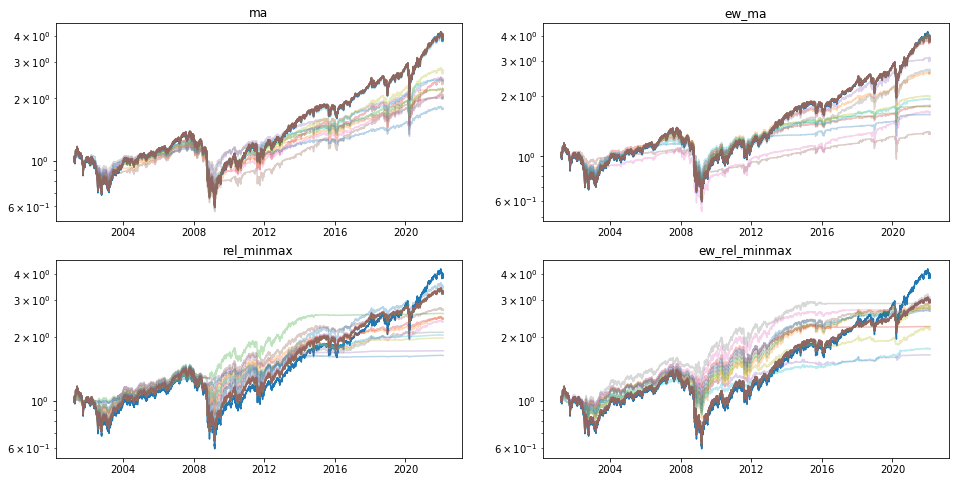

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.293947982104275
Refitting current best...
Current best ma returns: 7.908828228771013
Fraction Invested: 0.9949959196839988
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 7.908895001894736
Invested: 0.9949959196839988
New best: 7.908911378541762
Invested: 0.9949959196839988
New best: 7.914164707451911
Invested: 0.9971991588502481
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.293947982104275
Refitting current best...
Current best ew_ma returns: 8.090134168995995
Fraction Invested: 0.9980594882823609
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 8

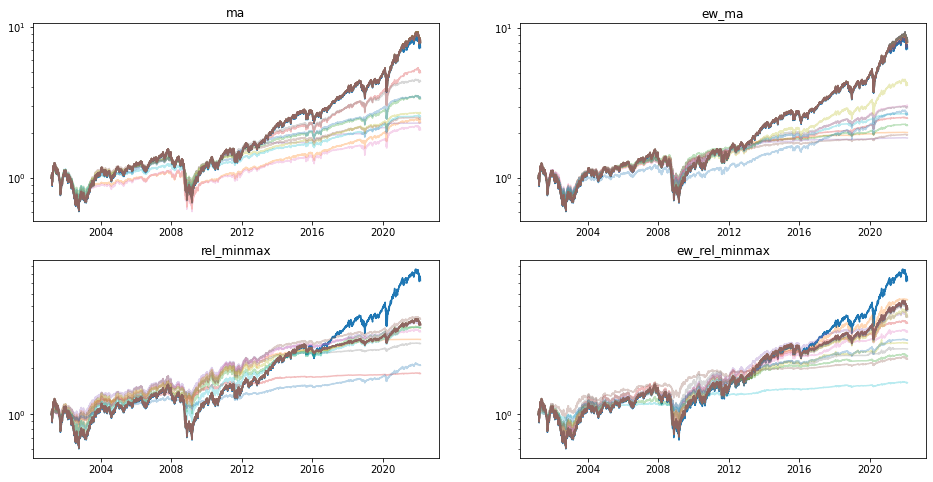

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.6431041546799237
Refitting current best...
Current best ma returns: 2.83611431633191
Fraction Invested: 0.9999998199151565
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 2.836469696805042
Invested: 0.9999998199151565
New best: 2.8366681275074788
Invested: 0.9999998199151565
New best: 2.8366803629724835
Invested: 0.9999998199151565
New best: 2.836720214283252
Invested: 0.9999998199151565
New best: 2.861966389601167
Invested: 0.9999998199151565
New best: 2.862638646611128
Invested: 0.9999998199151565
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.6431041546799237
Refitting curr

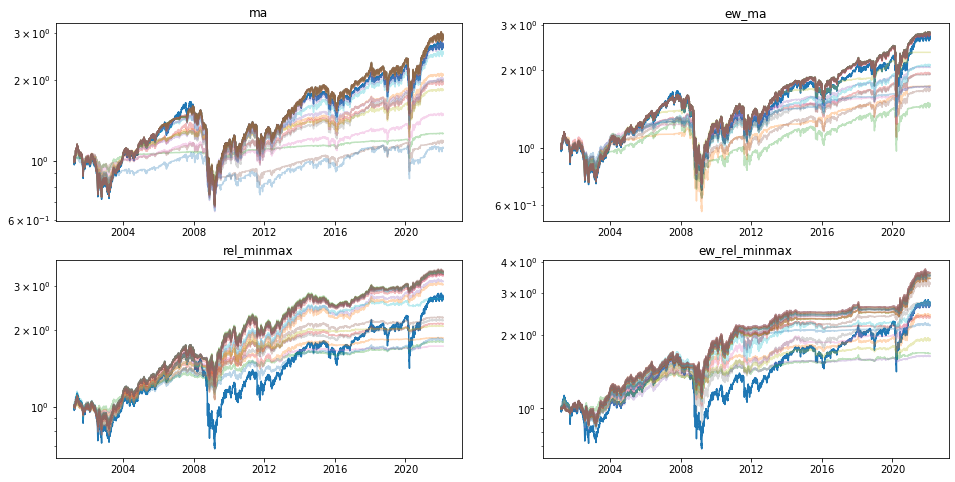

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.17602165017508
Refitting current best...
Current best ma returns: 4.365614645935397
Fraction Invested: 0.9948170198778029
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 4.3658141911813635
Invested: 0.9948170198778029
New best: 4.368266891041962
Invested: 0.9948170198778029
New best: 4.368524345938118
Invested: 0.9948170198778029
New best: 4.368738724783349
Invested: 0.9948170198778029
New best: 4.38970819869875
Invested: 0.9948170198778029
New best: 4.389957962273566
Invested: 0.9948170198778029



Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.17602165017508
Refitting current best...
C

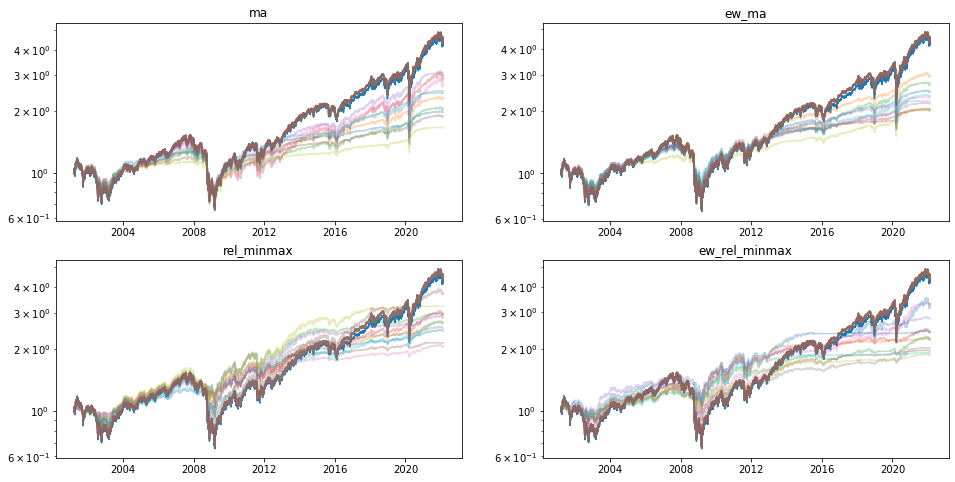

Saving ^W5000 params...


In [31]:
N_RAND = 10
N_ADJ = 15

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [32]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.3f} - {upper:.3f}): {pct:.3f}')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [33]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


^GSPC:
  Best Return: 3.916479759350862 (ma)
  95.59% in
time param: 1079
qs:
(0.000 - 0.337): 1.000
(0.337 - 0.423): 1.000
(0.423 - 0.480): 0.999
(0.480 - 0.495): 0.965
(0.495 - 0.540): 0.961
(0.540 - 0.570): 0.957
(0.570 - 0.978): 0.956
(0.978 - 0.979): 0.857
(0.979 - 0.986): 0.288
(0.986 - 1.000): 0.013

^IXIC:
  Best Return: 8.117762929359865 (ew_ma)
  99.81% in
time param: 1079
qs:
(0.000 - 0.373): 1.000
(0.373 - 0.454): 0.999
(0.454 - 0.490): 0.998
(0.490 - 0.502): 0.998
(0.502 - 0.941): 0.998
(0.941 - 0.961): 0.996
(0.961 - 0.963): 0.989
(0.963 - 0.986): 0.960
(0.986 - 0.988): 0.861
(0.988 - 1.000): 0.150

^NYA:
  Best Return: 3.6260645639725158 (ew_rel_minmax)
  2.73% in
time param: 432
qs:
(0.000 - 0.342): 0.919
(0.342 - 0.366): 0.882
(0.366 - 0.568): 0.871
(0.568 - 0.580): 0.747
(0.580 - 0.594): 0.594
(0.594 - 0.630): 0.480
(0.630 - 0.675): 0.406
(0.675 - 0.824): 0.139
(0.824 - 0.922): 0.105
(0.922 - 1.000): 0.027

^W5000:
  Best Return: 4.393731619917424 (rel_minmax)
  99.1

In [34]:
!say qp is dunzo

IXIC: Nasdaq